# Sections

[Objective](#Objective)  
[Setup](#Setup)  
[Load data](#Load-data)  
[Interest level](#Interest-level)  
[Numeric data](#Numeric-data)  
[Geographic data](#Geographic-data)  
[Nominal data](#Nominal-data)  
[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### How much interest will a new rental listing on RentHop receive?

In this <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, you will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

### File descriptions

- **```train.json```** - the training set
- **```test.json```** - the test set


### Data fields

- **```bathrooms:```** number of bathrooms
- **```bedrooms:```** number of bathrooms
- **```building_id```**
- **```created```**
- **```description```**
- **```display_address```**
- **```features:```** a list of features about this apartment
- **```latitude```**
- **```listing_id```**
- **```longitude```**
- **```manager_id```**
- **```photos:```** a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
- **```price:```** in USD
- **```street_address```**
- **```interest_level:```** this is the target variable. It has 3 categories: 'high', 'medium', 'low'


## Setup
[Back to top](#Sections)

In [1]:
from __future__ import print_function, division

In [2]:
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


Define functions for creating plots and summary tables.

In [4]:
# %load plots.py
def percentplot(data, var, title=None, xlabel='', ax=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(xlabel=xlabel if xlabel else '')
    ax.set(title=var if not title else title)
    return ax

    
def categoryplot(data, feature, category='interest_level', xlabel='', ax=None):
    values = pd.DataFrame()
    grouped = data.groupby([category, feature]).count()
    categories = data[category].cat.categories
    for c in categories:
        values[c] = grouped.xs(c).iloc[:,1]
    values = values.apply(lambda x: x * 100 / np.sum(x), axis=1)
    
    space = 0.1
    n = len(categories)
    width = (1.0 - space) / n
    
    xlabels = None
    for i, cat in enumerate(categories):
        percents = values.loc[:,cat]
        indices = range(len(percents))
        pos = [j - (1.0 - space) / n + i * width for j in indices]
        ax.bar(pos, percents, width=width, label=cat, color=sns.color_palette()[i])
        if i == 0:
            ax.set_xticks(indices)
            ax.set_xticklabels(percents.axes[0])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_ylabel('percent')
    ax.set_xlabel(xlabel if xlabel else '')
    return ax


def feature_hist(df, column, title=None, xlabel='', rotation=None):
    fig = plt.figure(figsize=(10, 8))
    ax1 = percentplot(df, column, title, xlabel=xlabel, ax=plt.subplot(211))
    ax2 = categoryplot(df, column, xlabel=xlabel, ax=plt.subplot(212))
    if rotation:
        for item in ax1.get_xticklabels():
            item.set_rotation(rotation)
        for item in ax2.get_xticklabels():
            item.set_rotation(rotation)
    fig.tight_layout()


## Load data
[Back to top](#Sections)

Open listings database

In [5]:
from pymongo import MongoClient

In [6]:
client = MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [7]:
pp_dict(collection.find_one())

loc,"{u'type': u'Point', u'coordinates': [-73.9389, 40.7245]}"
listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg


Copy listing, sans metadata, to dataframe.

In [8]:
%%time
c = collection.find({}, {'_id':0, 'id':0, 'building_id':0, 'manager_id':0, 'listing_id':0, 'photos':0})
df = pd.DataFrame(list(c))
df.interest_level = df.interest_level.astype('category', categories=['low', 'medium', 'high'])

CPU times: user 948 ms, sys: 1.08 s, total: 2.03 s
Wall time: 11 s


## Interest level
[Backl to top](#Sections)

The interest level is heavily skewed to 'low' and 'medium'

high,0.0778,low,0.6947,medium,0.2275


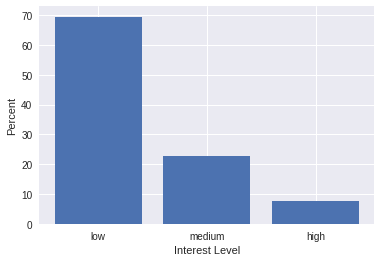

In [9]:
value_counts = df.interest_level.value_counts(normalize=True)
pp_counts(value_counts, caption='Interest levels:')

plt.bar(range(3), value_counts * 100, align='center')
plt.xticks(range(3), df.interest_level.cat.categories)
plt.xlabel('Interest Level')
plt.ylabel('Percent');

## Numeric data
[Back to top](#Sections)

### Price

Time could be a factor with prices, but since all the listings are from a three-month period, I need not be concerned.

In [10]:
pp_dict(OrderedDict([('First listing', np.min(df.created)), ('Last listing', np.max(df.created))]))

First listing,2016-04-01 22:12:41
Last listing,2016-06-29 21:41:47


The highest price is 4.5 million and there are six listings above so $100,000. I think those are all mistakes because they're for studio, one- and two-bedroom apartments. Drop them.

In [11]:
df[df.price>1e5][['bedrooms', 'bathrooms', 'price', 'interest_level']]

,bedrooms,bathrooms,price,interest_level
11191,2,1.0,4490000,low
12283,0,1.0,111111,high
13494,2,1.0,1150000,low
26830,0,0.0,135000,low
35191,1,1.0,1070000,low
35711,1,1.0,1070000,low


In [12]:
df = df.drop(df[df.price>1e5].index)

Bin prices in increments of 500 up to 10,000, then one bin for everything above that. The range 0 to 10,000 captures >98% of the listings, and of the few outside that range, >98% are low interest.

In [13]:
pp_counts(df[df.price>10000].interest_level.value_counts(normalize=True), 
          caption='Interest levels above $10,000:')

high,0.0023,low,0.9839,medium,0.0138


In [14]:
price_bins = range(0, 10001, 500) + [1e5]
bins = pd.cut(df.price, bins=price_bins)
df['price_bucket'] = bins.apply(lambda x: re.sub('\([0-9]+, ([0-9]+)\]', '\\1', x)).astype(int)

Observe below that price is definitely an important indicator for interest. The top graph is a histogram of all prices. The second graph is the histogram of interest at each price level. For example, there's little interest in listings priced above \$8,500, and high interest in listings in the \$1,500 bucket. 

500,0.0001,2000,0.0934,3500,0.1601,5000,0.0545,6500,0.0198,8000,0.0071,9500,0.0020
1000,0.0004,2500,0.1647,4000,0.1123,5500,0.0341,7000,0.0116,8500,0.0035,10000,0.0031
1500,0.0137,3000,0.1970,4500,0.0637,6000,0.0299,7500,0.0080,9000,0.0034,100000,0.0177


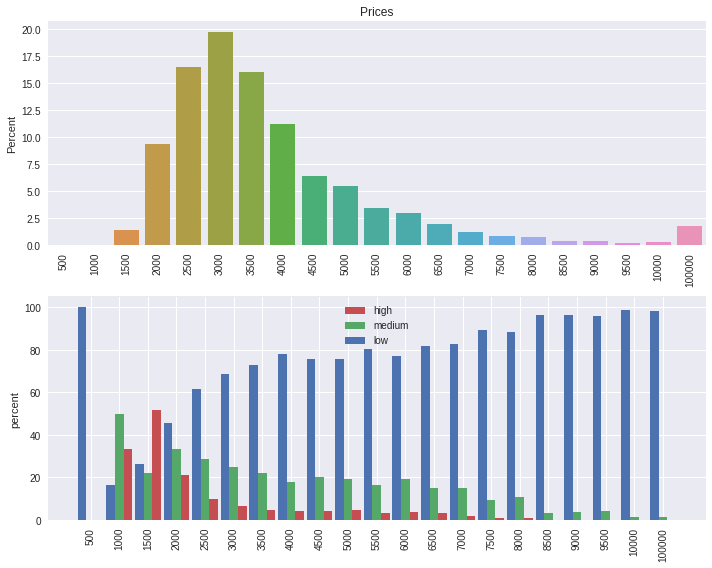

In [15]:
feature_hist(df, 'price_bucket', title='Prices', rotation=90)
pp_counts(df.price_bucket.value_counts(normalize=True), rows=3, caption='Price distribution:')

### Bedrooms

Eighty-percent of listings are for studios and one- and two-bedrooms apartments. Interest levels are steady up to four bedrooms, where it changes drastically. There are very few listings for apartments with five or more bedrooms, so sample size could be a factor.

0,0.1920,1,0.3192,2,0.2963,3,0.1474,4,0.0391,5,0.0050,6,0.0009,7,0.0000,8,0.0000


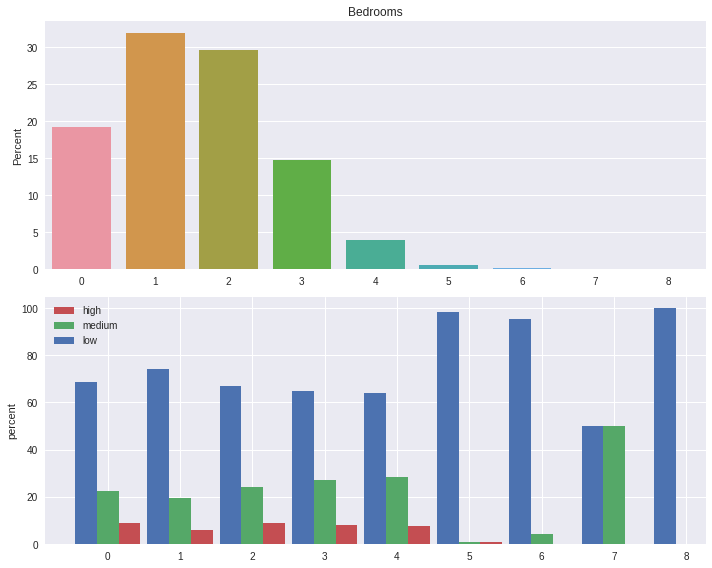

In [16]:
feature_hist(df, 'bedrooms', 'Bedrooms')
pp_counts(df.bedrooms.value_counts(normalize=True), caption='Bedrooms distribution:')

Not surprisingly, larger apartments have higher prices. What's potentially interesting is that all renters appear price-sensitive, with higher prices attracting less interest even for larger apartments.

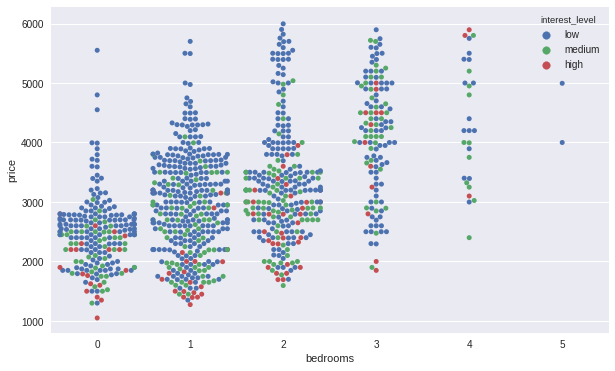

In [17]:
df2 = df[df.price < 6000].copy()
plt.figure(figsize=(10, 6))
sns.swarmplot(x='bedrooms', y='price', hue='interest_level', data=df2.sample(1000));

### Bathrooms

For completeness sake, look at the number of bathrooms.

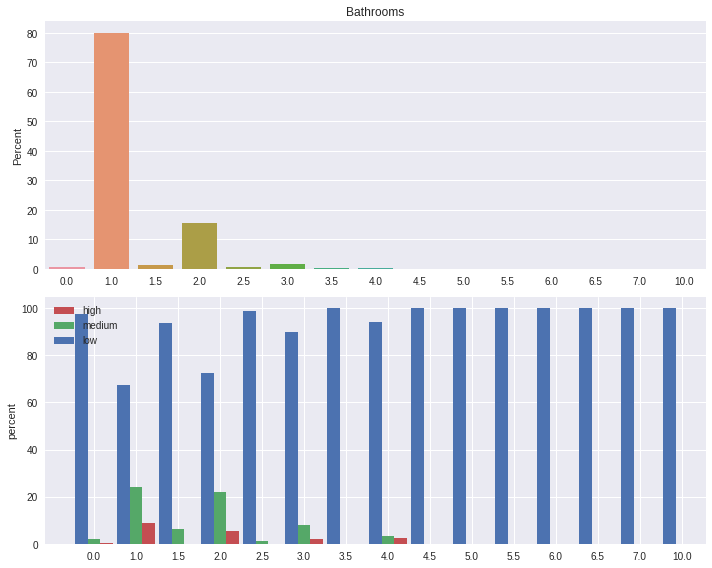

In [18]:
feature_hist(df, 'bathrooms', 'Bathrooms')
pp_counts(df.bathrooms.value_counts(normalize=True), rows=2, caption='Bathrooms distribution:')

## Geographic data
[Back to top](#Sections)

The cliche is that real estate is all about location, location, location. Let's see if that's true. We'll use GeoPandas to map listings.

In [19]:
import geopandas as gpd
from shapely.geometry import Point

Ignore listings outside New York to make the mapping easier. There are only a few of them.

In [20]:
geo_df = df.copy()
outside_nyc = geo_df[(geo_df.longitude < -74.2) | (geo_df.longitude > -73.7) | (geo_df.latitude < 40.5) | (geo_df.latitude > 40.9)]
geo_df = geo_df.drop(outside_nyc.index)
pp_bold('Ignoring {} listings, {} remain'.format(len(outside_nyc), len(geo_df)))

Plot the high, medium and low listings on a map to see if there's any obvious pattern or clustering. First load the shapefile of the five boroughs provide by NYC.gov.

In [21]:
nyc = gpd.GeoDataFrame.from_file('./data/nybb_17a/nybb.shp')
nyc = nyc.to_crs({'init' :'epsg:4326'})

This helper function plots the listing locations.

In [22]:
def plotpoints(df, ax=None, categories=['low', 'medium', 'high'], 
               colors=sns.color_palette('bright'), alpha=.25):
    for i, cat in enumerate(categories):
        points = df[df.interest_level == cat][['longitude', 'latitude']]
        points = gpd.GeoSeries([Point(x, y) for x, y in points.values])
        points.crs = {'init' :'epsg:4326'}
        points.plot(ax=ax, color=colors[i], markersize=5, alpha=alpha)

Plot 5000 listings, selected at random.

Observe there's no strong distinguishing pattern, but there does seems to be slightly higher interest in the lower rent areas (the Bronx, Lower East Side, Upper East Side and Midtown West). That's consistent with the previous observation that interest skews toward lower-priced listings.

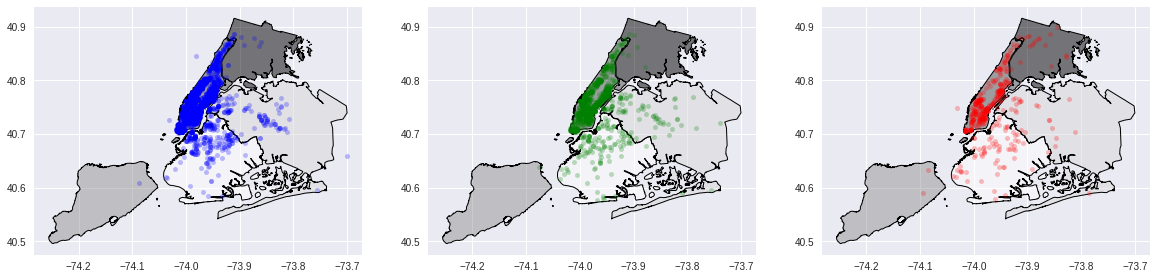

In [23]:
df_sample = geo_df.sample(5000)
plt.figure(figsize=(20, 10))

ax = plt.subplot(131)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['low'], colors=['b'])

ax = plt.subplot(132)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['medium'], colors=['g'])

ax = plt.subplot(133)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['high'], colors=['r'])

Plot an equal number of listings of each type, selected at random. The low interest listings are concentrated in Manhattan. There are a larger portion of medium and high interest listings in lower-prices areas of the Bronx, Brooklyn and Queens.

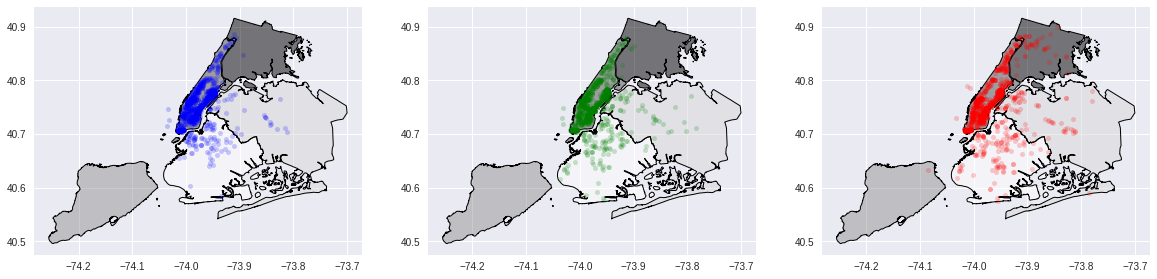

In [24]:
df_low = geo_df[geo_df.interest_level=='low'].sample(1000)
df_medium = geo_df[geo_df.interest_level=='medium'].sample(1000)
df_high = geo_df[geo_df.interest_level=='high'].sample(1000)
plt.figure(figsize=(20, 10))

ax = plt.subplot(131)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_low, ax=ax, categories=['low'], colors='b', alpha=.2)

ax = plt.subplot(132)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_medium, ax=ax, categories=['medium'], colors='g', alpha=.2)

ax = plt.subplot(133)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_high, ax=ax, categories=['high'], colors='r', alpha=.2)

What's the relationship between location, price and interest level?

In [25]:
from mpl_toolkits.mplot3d import Axes3D

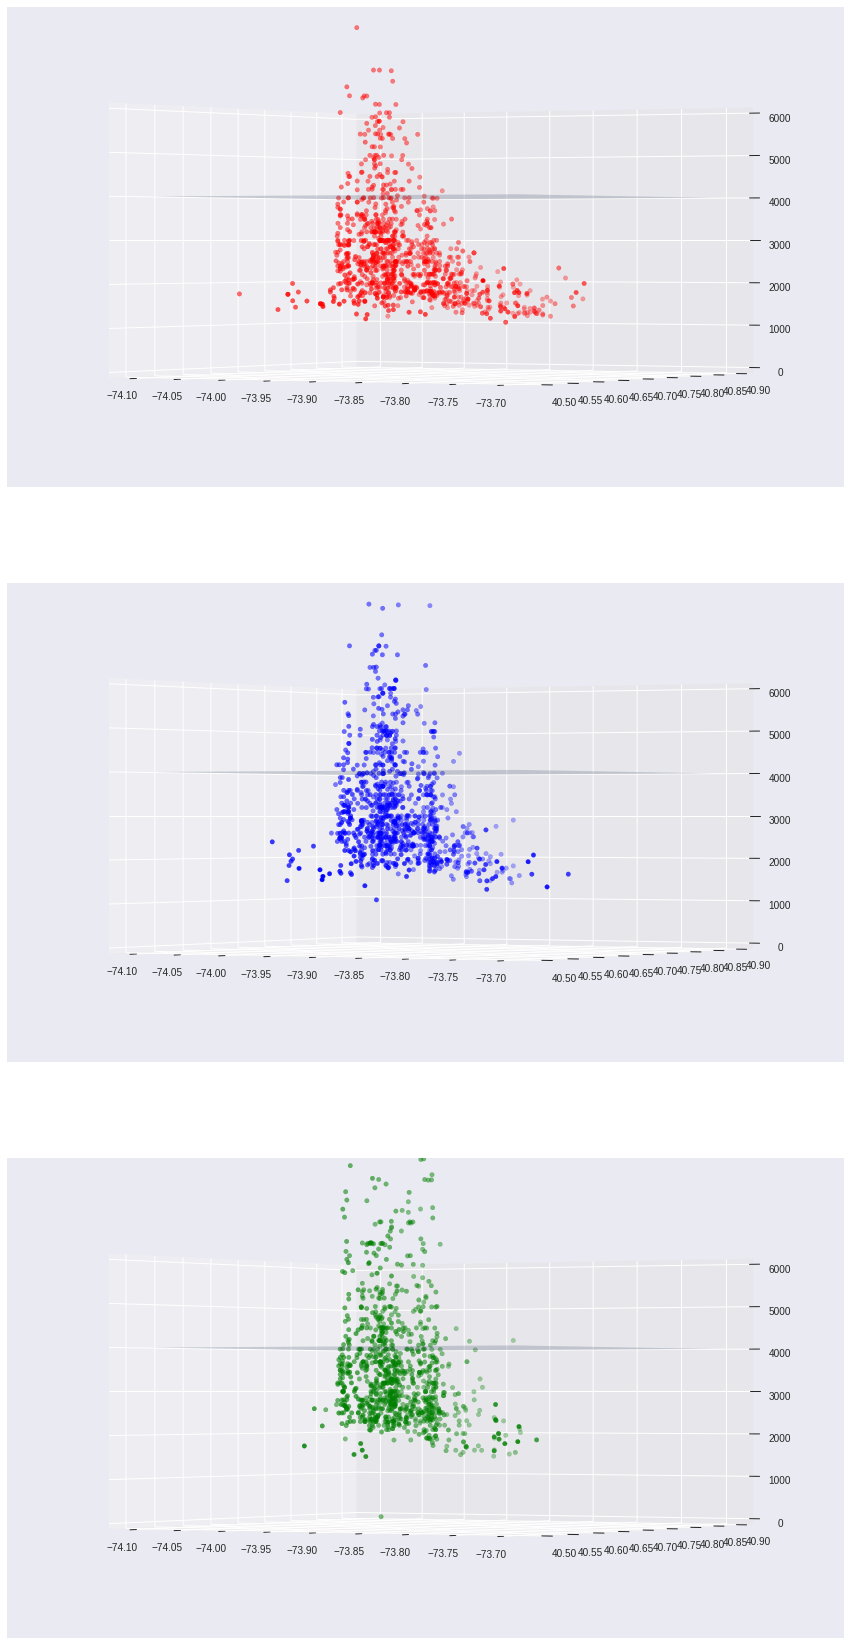

In [26]:
def price3dplot(df, ax, color, zplane=4000, zlimit=(0, 6000)):
    ax.view_init(elev=0)
    ax.set_zlim(*zlimit)
    ax.scatter(df.longitude, df.latitude, df.price, c=[color]*len(df))
    xx, yy = np.meshgrid(np.linspace(-74.1, -73.7, 20), np.linspace(40.5, 40.9, 20))
    ax.plot_surface(xx, yy, [zplane]*len(xx), alpha=0.2)
    return ax

fig = plt.figure(figsize=(15, 30))
price3dplot(df_high, fig.add_subplot(311, projection='3d'), 'r')
price3dplot(df_medium, fig.add_subplot(312, projection='3d'), 'b')
price3dplot(df_low, fig.add_subplot(313, projection='3d'), 'g')
plt.show()

## Nominal data
[Back to top](#Sections)

In [27]:
cat_df = df.copy()

### Street address

Do similarly priced listings at the same address attract the same interest? To find out, identify listings at the same address, group them by size and price bucket, and count how many groups have mixed interest. It's about 50/50. Clearly there's another factor besides location, size and price.

In [28]:
subset = cat_df[cat_df.duplicated(subset='street_address', keep=False)].copy()
groups = subset.groupby(['street_address', 'bedrooms', 'bathrooms', 'price_bucket'])

mixed = []
total = 0
for k, v in groups.groups.items():
    if len(v) > 1:
        total += 1
        if 1 < len(np.unique(cat_df.loc[v].interest_level)):
            mixed.append(v)
            
pp_bold('{0} ({2:.2%}) of {1} similar listings attract mixed interest'.format(len(mixed), total, len(mixed) / total))

Here's an example of mixed interest.

In [29]:
subset.loc[mixed[1]][['created', 'street_address', 'bedrooms', 'bathrooms', 'price', 'interest_level']]

,created,street_address,bedrooms,bathrooms,price,interest_level
26596,2016-04-25 02:51:39,310 East 2nd Street,2,1.0,3507,medium
35391,2016-04-15 05:20:12,310 East 2nd Street,2,1.0,3507,medium
37672,2016-05-18 01:38:18,310 East 2nd Street,2,1.0,3554,low
42538,2016-04-06 07:15:17,310 East 2nd Street,2,1.0,3508,low


The listing's above are close to identical. Could time be a factor? Perhaps interest rises and wanes at different times of the month? To find out, I segment listings by week in the month. The listings are evenly distributed (except for the 'fifth' week which is always a shorter than the others) and the interest levels are constant. It's a small effect, but interest does peak in the first week, then drops steadily.

1,0.2309,2,0.2535,3,0.2500,4,0.2176,5,0.0480


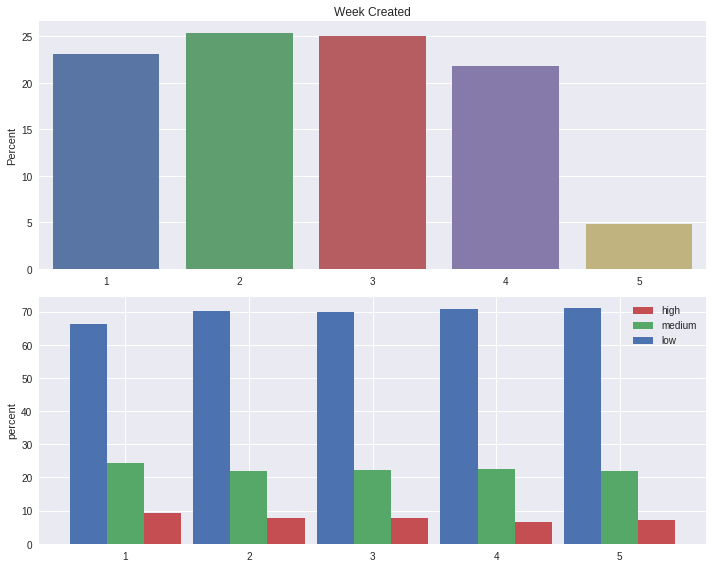

In [30]:
df['week_created'] = pd.to_datetime(df.created).apply(lambda x: -(-x.day // 7))
feature_hist(df, 'week_created', 'Week Created')
pp_counts(df.week_created.value_counts(normalize=True), caption='Weekly distribution:')

What about by day of the month? Observe interest appears to rise and fall periodically. 

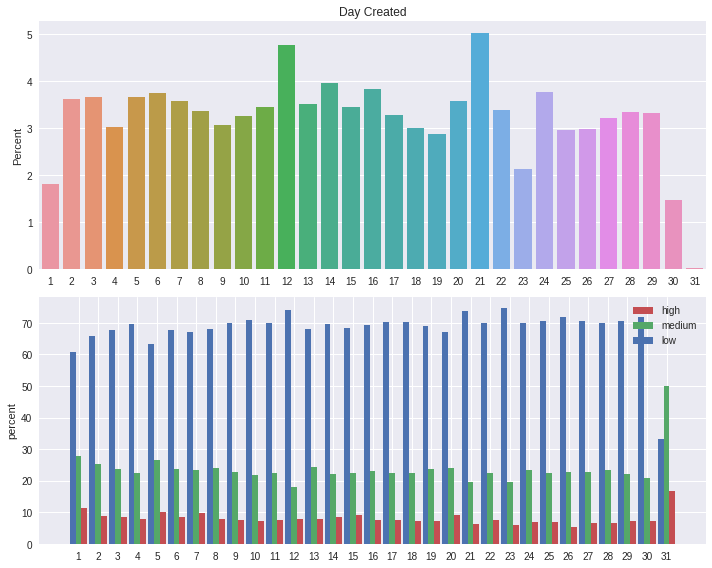

In [31]:
df['day_created'] = pd.to_datetime(df.created).apply(lambda x: x.day)
feature_hist(df, 'day_created', 'Day Created')
pp_counts(df.day_created.value_counts(normalize=True), rows=3, caption='Daily distribution:')

Is it a weekday/weekend cycle? See the plot below where Monday is zero. No, it's not the weekends, thought there is a slight uptick in interest on Thursday.

0,0.0859,1,0.1705,2,0.1908,3,0.1661,4,0.1538,5,0.1409,6,0.0920


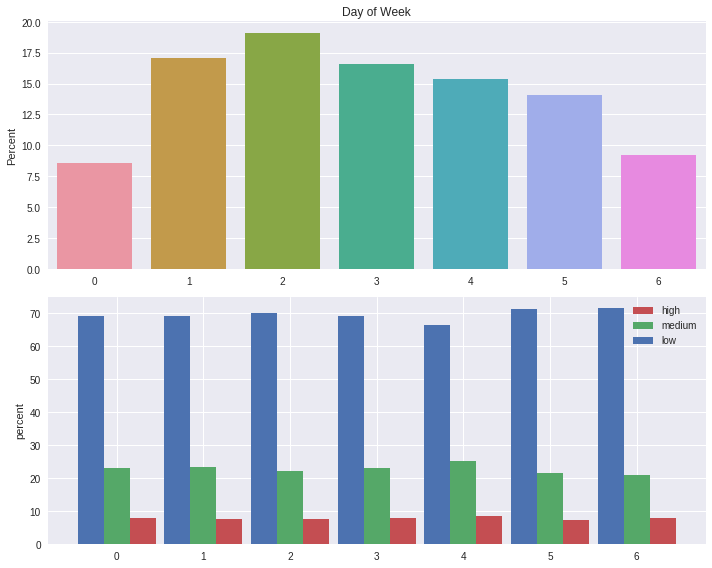

In [32]:
df['dayofweek'] = pd.to_datetime(df.created).apply(lambda x: x.weekday())
feature_hist(df, 'dayofweek', 'Day of Week')
pp_counts(df.dayofweek.value_counts(normalize=True), caption='Day of week distribution:')

### Features
[Back to top](#Sections)

The "features" field is a non-standardized list of attributes of the apartment/building. The same attribute appears in different forms. For example, the following terms are all used to describe that the apartment has a washer and dryer: 

- "laundry in unit"
- "washer in unit"
- "dryer in unit"
- "washer/dryer"
- "washer & dryer"
- "in unit washer/dryer"
- "washer/dryer in unit"

To clean this up, first map all aliases to a single canonical term. The aliases are stored in a JSON file that lists the recognized aliases for each term. For example:

```python
{ "bike-room" : [
    "bike storage"
]},
{ "central air" : [
    "central a/c", "central ac"
]},
{"common outdoor space" : [
    "roof deck", "publicoutdoor", 
    "common terrace", "roofdeck", "building common outdoor space",
    "residents garden", "outdoor areas", "common roof deck",
    "courtyard", "common garden", "rooftop deck", "common backyard",
    "rooftop terrace", "deck", "shared backyard"
]},
```

The file also collapses some related terms into a single concept, e.g., ```common outdoor space```.

In [273]:
import json

In [274]:
# Load JSON file into dictionary mapping synonyms to canonical terms
with open('synonyms.json') as fd:
    synomyns = json.load(fd)
canon = {alias : term for s in synomyns for term, aliases in s.items() for alias in aliases}

def unalias(name):
    """
    Look up the canonical version of a string. Returns the
    original string when none is found.
    """
    return canon.get(name, name)

Now we can count how many unique features. There are over eleven hundred! But, most of these are junk and only appear a handful of times.

In [277]:
all_features = Counter()
for l in df.features:
    unit_features = l.lower().replace('-', ' ').split('\n')
    all_features.update([unalias(f) for f in unit_features if f])
pp_bold('{} unique features'.format(len(all_features)))

Let's examine the top fity terms. Observe the prevalence drops off  dramtically.

In [285]:
pp_dict(OrderedDict(all_features.most_common(50)), rows=15)

## Scratchpad
[Back to top](#Sections)